In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt


In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#Here, we create a dictionary out of the dataframe that has as a key the exposures and as 
#values the set of the genes that they perturb
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        

        

In [4]:
chem_gene_cleaned = {}
tot_genelist = []
for chem,geneset in chem_gene.items():
    n_genelist = [el for el in geneset if str(geneset)!='nan']
    tot_genelist.extend(n_genelist)
    if len(n_genelist)>0:
        chem_gene_cleaned[chem] = n_genelist

In [19]:
tot_genelist_counter = dict(Counter(tot_genelist))

In [20]:
ppi = pd.read_csv("autocore_symbol_lcc.csv",delimiter= ',',
           skipinitialspace=True)

G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')

G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

18815
482935


In [23]:

import scipy

frequency_list=[]
degree_list=[]
for g in G_ppi_lcc.nodes():
    if g in tot_genelist_counter:
        degree_list.append(G_ppi_lcc.degree(g))
        frequency_list.append(tot_genelist_counter[g])



print(scipy.stats.pearsonr(frequency_list,degree_list))  # Pearson's r
print(scipy.stats.spearmanr(frequency_list,degree_list)) # Spearman's rho

PearsonRResult(statistic=0.23729929599830607, pvalue=3.928859999541439e-229)
SignificanceResult(statistic=0.39046001227706634, pvalue=0.0)


In [6]:
def jaccard_index(setA, setB):
    inter = len(setA & setB)
    union = len(setA | setB)
    return inter / union if union else 0

In [11]:
from scipy import stats
def overlap_set(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= background 
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

In [132]:
import random
from collections import Counter

def randomize_preserve_nodes_edges_exact(chem_gene_cleaned, seed=42, max_attempts=100):
    """
    Randomized reassignment that exactly preserves:
      - per-chemical degree (len of gene set per chemical)
      - per-gene degree (global counts of how many chemicals point to each gene)
      - therefore same total edges and same set size of genes

    Parameters
    ----------
    chem_gene_cleaned : dict
        mapping chemical -> iterable of gene IDs (original bipartite)
    seed : int
        random seed
    max_attempts : int
        number of global randomized retries before giving up

    Returns
    -------
    mapping : dict chemical -> list of genes (randomized)
    """
    random.seed(seed)

    # Precompute degrees and gene capacities
    chem_degs = {c: len(gs) for c, gs in chem_gene_cleaned.items()}
    gene_capacity = Counter(g for gs in chem_gene_cleaned.values() for g in gs)
    total_edges = sum(chem_degs.values())
    original_genes = list(gene_capacity.keys())
    n_genes = len(original_genes)

    # Quick sanity
    assert sum(gene_capacity.values()) == total_edges, "Internal count mismatch"

    for attempt in range(1, max_attempts + 1):
        gene_rem = dict(gene_capacity)         # remaining capacity per gene
        available = {g for g, rem in gene_rem.items() if rem > 0}  # set of genes with rem>0
        mapping = {}
        failed = False

        # iterate chemicals in random order (bias to large-first reduces starvation)
        chems = list(chem_gene_cleaned.keys())
        random.shuffle(chems)
        chems.sort(key=lambda c: -chem_degs[c])  # large-first but randomized tie-breaking

        for c in chems:
            k = chem_degs[c]
            if len(available) < k:
                failed = True
                break

            # sample k distinct genes from available (uniformly)
            chosen = random.sample(list(available), k)

            # assign and decrement capacities
            mapping[c] = chosen
            for g in chosen:
                gene_rem[g] -= 1
                if gene_rem[g] == 0:
                    available.remove(g)

        # check if we've consumed all capacities exactly
        if not failed and all(rem == 0 for rem in gene_rem.values()):
            # Success: mapping preserves per-gene counts and per-chem degrees
            return mapping

        # else retry with new randomization
        # (loop continues)
    # if reached here, attempts exhausted
    raise RuntimeError(
        f"Failed to build exact-preserving randomization in {max_attempts} attempts. "
        "Try increasing max_attempts or shuffle strategy."
    )

In [133]:
mapping = randomize_preserve_nodes_edges_exact(chem_gene_cleaned, seed=1, max_attempts=50)

# Verify edges
orig_edges = sum(len(v) for v in chem_gene_cleaned.values())
new_edges  = sum(len(v) for v in mapping.values())
print("edges equal?", orig_edges == new_edges)

# Verify node set
orig_nodes = set(g for gs in chem_gene_cleaned.values() for g in gs)
new_nodes  = set(g for gs in mapping.values() for g in gs)
print("nodes equal?", orig_nodes == new_nodes)

# Verify per-gene degrees preserved
from collections import Counter
orig_gene_counts = Counter(g for gs in chem_gene_cleaned.values() for g in gs)
new_gene_counts  = Counter(g for gs in mapping.values() for g in gs)
print("per-gene degrees equal?", orig_gene_counts == new_gene_counts)

edges equal? True
nodes equal? True
per-gene degrees equal? True


In [ ]:
with open('output/chem_random_stochastic.pickle', 'wb') as handle:
    pk.dump(mapping, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
with open('output/chem_random_stochastic.pickle', 'rb') as handle:
    chem_random_stochastic = pk.load(handle)

In [172]:
ji_list = []

for chem,genelist in mapping.items():
    ji = jaccard_index(set(genelist),set(chem_gene_cleaned[chem]))
    ji_list.append(ji)

print(np.mean(ji_list))

0.019460764216256442


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_83433/948518836.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


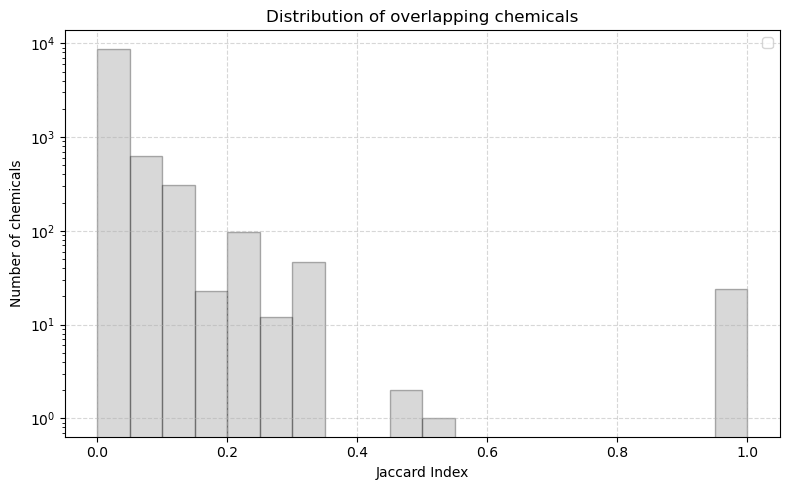

In [173]:
# Prepare the data

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(ji_list, bins=20, color='grey', edgecolor='black', alpha=0.3)
plt.title("Distribution of overlapping chemicals")
plt.xlabel("Jaccard Index")
plt.ylabel("Number of chemicals")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('Figures/RandomBipartite_ChemicalOverlap.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()

In [143]:
gene_chem_random = {}
for chem,geneset in mapping.items():
    for g in geneset:
        try:
            gene_chem_random[g] |= {chem}
        except KeyError as e:
            gene_chem_random[g] = set([chem])

In [169]:
gene_chem_cleaned = {}
for chem,geneset in chem_gene_cleaned.items():
    for g in geneset:
        try:
            gene_chem_cleaned[g] |= {chem}
        except KeyError as e:
            gene_chem_cleaned[g] = set([chem])

In [174]:
ji_list = []

for gene,chemlist in gene_chem_random.items():
    ji = jaccard_index(set(chemlist),set(gene_chem_cleaned[gene]))
    ji_list.append(ji)

print(np.mean(ji_list))

0.12048421519976288


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_83433/300605998.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


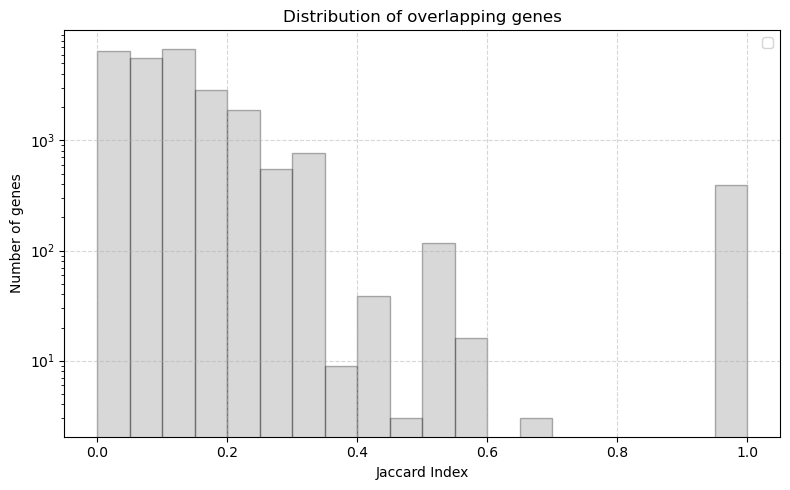

In [ ]:

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(ji_list, bins=20, color='grey', edgecolor='black', alpha=0.3)
plt.title("Distribution of overlapping genes")
plt.xlabel("Jaccard Index")
plt.ylabel("Number of genes")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('output/Figures/RandomBipartite_GeneticOverlap.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()

In [135]:
#We create a bipartite network for exposures and perturbed genes
bipartite_G = nx.Graph()
exposures_list = []
genes_list = []
for k,v in mapping.items():
    exposures_list.append(k)
    for gene in v:
        genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G.add_node(exposure,s="o", bipartite='exposure')
    for genes in mapping[exposure]:
        bipartite_G.add_edges_from([(exposure,genes)])

In [136]:
bipartite_G.number_of_nodes()

35467

In [137]:
bipartite_G.number_of_edges()

573674

In [138]:
#Let's select the top 100 perturbed genes by frequency
gene_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'gene']
genes_degree_dict = nx.bipartite.degree_centrality(bipartite_G, gene_nodes)
gene_nodes_with_centrality={}
for k in genes_degree_dict.keys():
    if k in gene_nodes:
        gene_nodes_with_centrality[k]=genes_degree_dict[k]
        
gene_nodes_with_centrality_sorted = dict(sorted(gene_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = gene_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]


In [139]:
with open('d_classes.pickle', 'rb') as handle:
    d_classes = pk.load(handle)

In [140]:
#Let's convert the 12 classes to names 
chem_class_name_dict={}
chem_class_name_dict['D011083']='Polycyclic Compounds'
chem_class_name_dict['D006571']='Heterocyclic Compounds'
chem_class_name_dict['D008055']='Lipids'
chem_class_name_dict['D009930']='Organic Chemicals'
chem_class_name_dict['D045424']='Complex Mixtures'
chem_class_name_dict['D007287']='Inorganic Chemicals'
chem_class_name_dict['D002241']='Carbohydrates'
chem_class_name_dict['D001685']='Biological Factors'
chem_class_name_dict['D000602']='Amino Acids, Peptides, and Proteins'
chem_class_name_dict['D020164']='Chemical Actions and Uses'
chem_class_name_dict['D045762']='Enzymes and Coenzymes'
chem_class_name_dict['D009706']='Nucleic Acids, Nucleotides, and Nucleosides'





In [141]:
class_color_dict = {}

class_color_dict['D011083']='#00AEEF'
class_color_dict['D006571']='#64A8C5'
class_color_dict['D008055']='#FBB040'
class_color_dict['D009930']='#44C8F5'
class_color_dict['D045424']='#F79D8D'
class_color_dict['D007287']='#BCBEC0'
class_color_dict['D002241']='#FECD8A'
class_color_dict['D001685']='#F15A29'
class_color_dict['D000602']='#F9A86B'
class_color_dict['D020164']='#FFE6CB'
class_color_dict['D045762']='#D56B4C'
class_color_dict['D009706']='#C65D7D'

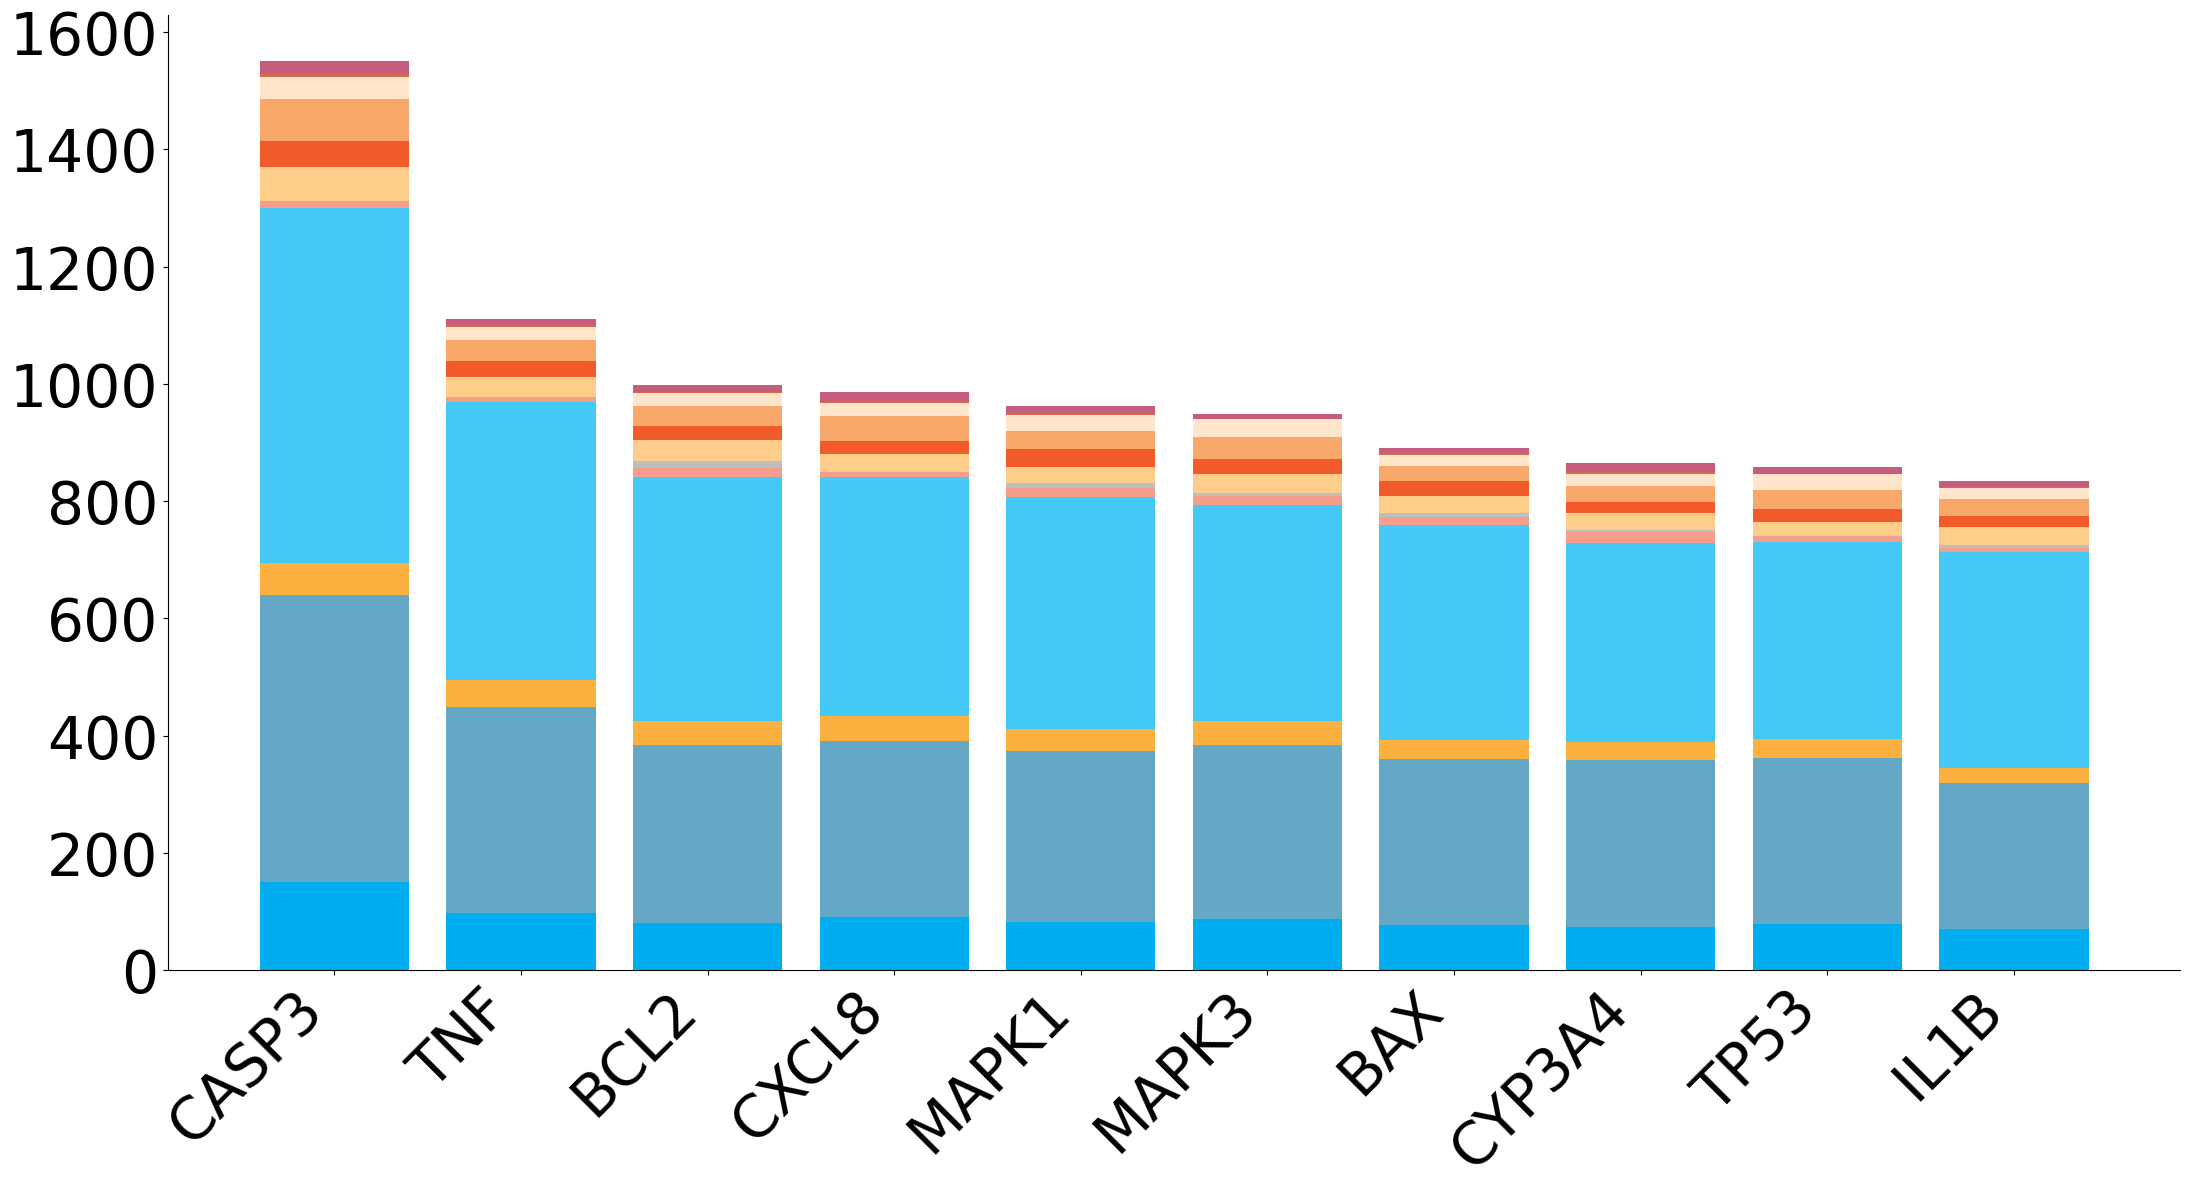

In [ ]:
#Here, we show the distribution of the top 100 genes perturbed by frequencies
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator




fig1, ax1 = plt.subplots(figsize=(22, 12))
label=[]
gene_class_comp_dict={}
for i in range(len(first_ten)):
    label.append(first_ten[i][0])  
    gene_comp={}
    for chem in gene_chem_random[first_ten[i][0]]:
        class_list=[]
        for chem_class,chem_list in d_classes.items():
            if chem in chem_list:
                class_list.append(chem_class)
        gene_comp[chem]=class_list
        chem_class_name_gene={}
        for chem_class_name in d_classes.keys():
            count=0
            for chem, class_list in gene_comp.items():
                if chem_class_name in class_list:
                    count=count+(1/len(class_list))
            chem_class_name_gene[chem_class_name]=count
    gene_class_comp_dict[first_ten[i][0]]=chem_class_name_gene
    
    
gene_classes_list=[]
for chem_class_name in d_classes.keys():
    chem_class_value_list=[]
    for gene in label:
        chem_class_value_list.append(gene_class_comp_dict[gene][chem_class_name])
    gene_classes_list.append(chem_class_value_list)

    
x = np.arange(10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



ax1.bar(label, gene_classes_list[0], label=chem_class_name_dict[list(d_classes.keys())[0]],color=class_color_dict[list(d_classes.keys())[0]])
ax1.bar(label, gene_classes_list[1], bottom=gene_classes_list[0],  label=chem_class_name_dict[list(d_classes.keys())[1]],color=class_color_dict[list(d_classes.keys())[1]])
ax1.bar(label, gene_classes_list[2], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1]),  label=chem_class_name_dict[list(d_classes.keys())[2]],color=class_color_dict[list(d_classes.keys())[2]])
ax1.bar(label, gene_classes_list[3], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2]),  label=chem_class_name_dict[list(d_classes.keys())[3]],color=class_color_dict[list(d_classes.keys())[3]])
ax1.bar(label, gene_classes_list[4], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3]),  
        label=chem_class_name_dict[list(d_classes.keys())[4]],color=class_color_dict[list(d_classes.keys())[4]])
ax1.bar(label, gene_classes_list[5], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4]),
        label=chem_class_name_dict[list(d_classes.keys())[5]],color=class_color_dict[list(d_classes.keys())[5]])
ax1.bar(label, gene_classes_list[6], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5]),
        label=chem_class_name_dict[list(d_classes.keys())[6]],color=class_color_dict[list(d_classes.keys())[6]])
ax1.bar(label, gene_classes_list[7], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6]),
        label=chem_class_name_dict[list(d_classes.keys())[7]],color=class_color_dict[list(d_classes.keys())[7]])
ax1.bar(label, gene_classes_list[8], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7]),
        label=chem_class_name_dict[list(d_classes.keys())[8]],color=class_color_dict[list(d_classes.keys())[8]])
ax1.bar(label, gene_classes_list[9], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8]),
        label=chem_class_name_dict[list(d_classes.keys())[9]],color=class_color_dict[list(d_classes.keys())[9]])
ax1.bar(label, gene_classes_list[10], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9]),
        label=chem_class_name_dict[list(d_classes.keys())[10]],color=class_color_dict[list(d_classes.keys())[10]])
ax1.bar(label, gene_classes_list[11], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9])+np.array(gene_classes_list[10]),
        label=chem_class_name_dict[list(d_classes.keys())[11]],color=class_color_dict[list(d_classes.keys())[11]])


#plt.title('Frequency of genes affected by exposures',fontsize=32)
#plt.ylabel('Number of associated exposures',fontsize=40)
#plt.xlabel('Genes',fontsize=40)
plt.xticks(x, label,fontsize=42,rotation=45,ha='right')
plt.yticks(fontsize=42)
plt.tight_layout()
plt.savefig('output/Figures/RandomBipartite_TopGenes.pdf',format='pdf',dpi=300, bbox_inches = "tight") 
plt.show()

In [145]:
#Let's select the top 100 exposures for number of genes that they perturb
exposure_nodes = [node for node in B_null.nodes() if B_null.nodes[node]['bipartite'] == 'chem']
exposure_degree_dict = nx.bipartite.degree_centrality(B_null, exposure_nodes)
exposures_nodes_with_centrality={}
for k in exposure_degree_dict.keys():
    if k in exposure_nodes:
        exposures_nodes_with_centrality[k]=exposure_degree_dict[k]
        
exposures_nodes_with_centrality_sorted = dict(sorted(exposures_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = exposures_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]



In [146]:
chem_id_name_conversion = {}
for i,v in chem_homo.iterrows():
        chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_83433/3818284625.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)


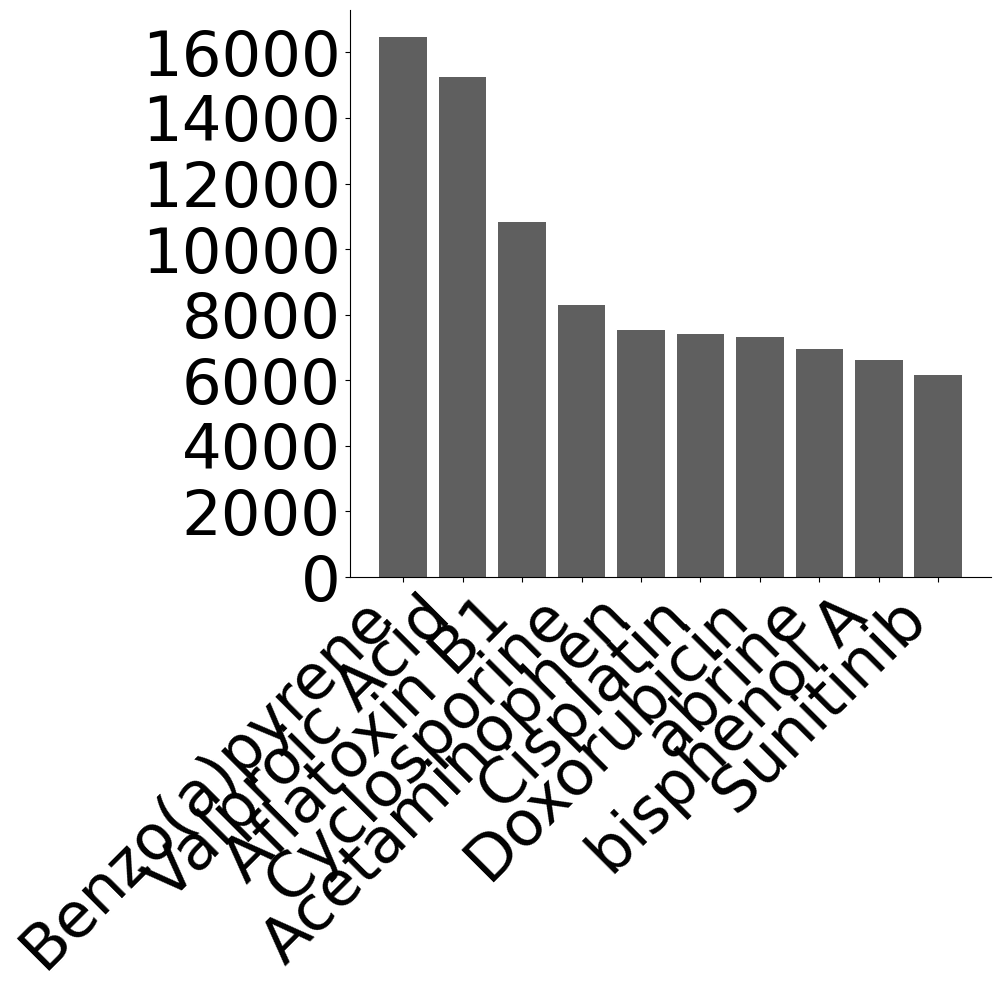

In [ ]:
#Let's plot it, color them by their chemical class of belonging 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
new_label=[]
frequency=[]
for i in range(len(first_ten)):
    label.append(first_ten[i][0])
    frequency.append(len(mapping[first_ten[i][0]]))
    chem_name=chem_id_name_conversion[first_ten[i][0]]
    if len(chem_name)<20:
        new_label.append(chem_name)
    else:
        new_label.append(first_ten[i][0])

x = np.arange(10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



    
plt.bar(x, frequency,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Exposures',fontsize=20)
#plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.yticks(fontsize=45)
plt.tight_layout()

    
plt.savefig('output/Figures/RandomBipartite_TopExp.pdf',format='pdf',dpi=300, bbox_inches = "tight") 
plt.show()                                                                               

In [84]:
#Let's plot the distribution

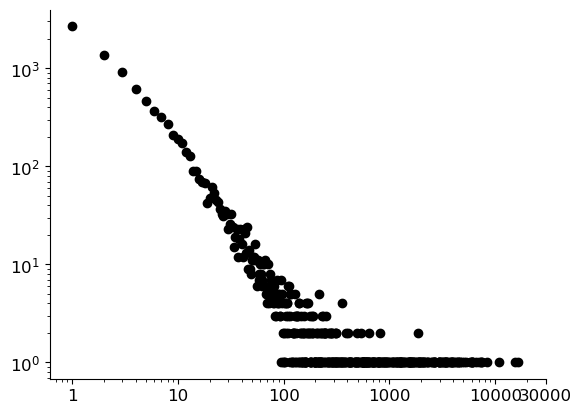

In [ ]:
import matplotlib.ticker

exposure_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'exposure']
#Get the exposure degree
exposures_degree_dict = dict(nx.bipartite.degrees(bipartite_G,exposure_nodes)[1])
#Get the unique PPI degree steps
degrees_exposures_unique = list(set(exposures_degree_dict.values()))
degrees_exposures_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesexposures = []

#Normal distribution (i.e. P(k = x))
degreeDistributionexposures = []
degreeDistributionexposurescount = []

for degree in degrees_exposures_unique:
    degreesexposures.append(degree)
    degreeDistributionexposures.append(list(exposures_degree_dict.values()).count(degree)/float(len(exposures_degree_dict)))
    degreeDistributionexposurescount.append(list(exposures_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesexposures, degreeDistributionexposurescount,c='black',marker="o", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,10000,30000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/Random_Bipartite_ExpDistribution.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

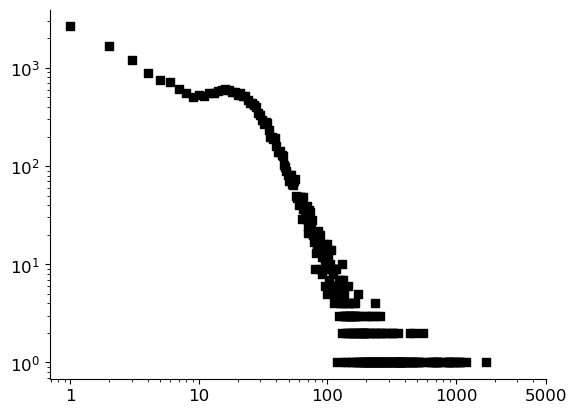

In [ ]:
import matplotlib.ticker

gene_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'gene']
#Get the genes degree
genes_degree_dict = dict(nx.bipartite.degrees(bipartite_G,gene_nodes)[1])
#Get the unique PPI degree steps
degrees_genes_unique = list(set(genes_degree_dict.values()))
degrees_genes_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesgenes = []

#Normal distribution (i.e. P(k = x))
degreeDistributiongenes = []
degreeDistributiongenescount = []

for degree in degrees_genes_unique:
    degreesgenes.append(degree)
    degreeDistributiongenes.append(list(genes_degree_dict.values()).count(degree)/float(len(genes_degree_dict)))
    degreeDistributiongenescount.append(list(genes_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesgenes, degreeDistributiongenescount,c='black',marker="s", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,5000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/RandomBipartite_GeneDistribution.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()
